In [1]:
import pickle
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from collections import Counter
import umap
import networkx as nx
from itertools import permutations 
import hdbscan
import numpy as np
from mechanism_solver import MechanismAStarSolver, MechanismDynamicSolver
from approval_profile import *
from mechanism import *
import copy
import numba


In [2]:
def axiom(projects, ballots, labels, costs, budget):
    n_clusters = max(labels) + 1
    clusters = [ballots[labels == i] for i in range(n_clusters)]
    b = [] 
    r = []
    for cluster in clusters:
        b.append(np.sum(np.mean(cluster,0)[projects]*costs[projects])/budget)
        r.append(len(cluster)/len(ballots))
    b = np.array(b)
    b /= sum(b)
    s = 0
    for x,y in zip(b,r):
        s += np.abs(x-y)**2
        print(f"{(x-y):.3f}")
    print(s)


In [3]:
with open("data//sorted_files.pkl", 'rb') as f:
    file_division = pickle.load(f)
    
approval_profile_files = sorted(file_division['approval'], key=lambda x: x[2], reverse=True)
profile = Profile(approval_profile_files[6][0])


In [20]:
profile = Profile_Synthetic(list(range(4000, 1, -200)), list(range(1000, 1, -50)), budget_distribution=uniform, low=500, high=10000, spread_of_approvals=2.5, sdcavpd=0.3, noise=0.02)

In [21]:
# profile = Profile_Synthetic.load('gen_data//55000_20_liniear.pb')
data = profile.ballots.astype(int)
subdata = copy.deepcopy(data)
np.random.shuffle(subdata)
# old_clusters = profile.clusters
# old_labels = [j for i,cluster in enumerate(old_clusters) for j in len(cluster)*[i]]
old_labels = [sum(x) for x in data]

In [22]:
np.set_printoptions(threshold=10000)
x,y = np.unique(profile.ballots, return_counts=True, axis=0)
print(len(y), len(profile.ballots))
print(profile.approvals)
z,w = np.unique(np.sum(profile.ballots, 1), return_counts=True)
list(zip(z,w))
# sorted(y, reverse=True)


3222 10500
[4156. 3052. 3564. 2930. 3345. 3252. 3420. 2630. 3131. 2357. 1785. 1856.
 1650. 2345. 1640. 1197.  856.  704.  452.  391.]


[(1.0, 1328),
 (2.0, 1641),
 (3.0, 1339),
 (4.0, 1530),
 (5.0, 1402),
 (6.0, 1306),
 (7.0, 928),
 (8.0, 753),
 (9.0, 168),
 (10.0, 76),
 (11.0, 21),
 (12.0, 7),
 (13.0, 1)]

In [33]:
# Marina Meila - ComparingClusterings An Axiomatic View
# take cost into count

# @numba.njit()
# def XOR_dist(a,b):
#     XOR = np.logical_xor(a,b).sum()
#     OR =  np.logical_or(a,b).sum()
#     return (len(a) + XOR - OR) / (len(a) + OR - XOR) 

@numba.njit()
def XOR_dist(a,b):
    XOR = np.logical_xor(a,b).sum()
    OR =  np.logical_or(a,b).sum()
    AND = np.logical_and(a,b).sum() 
    avg = (a.sum() + b.sum()) / 2
    
#     return XOR 
#     return OR - AND
#     return avg - AND
    try:
#         return XOR / avg
        return XOR / (len(a) - avg + AND)
#         return 1 - AND / OR
#         return OR / AND - 1
#         return (XOR - AND) / (AND)
#         return (XOR + avg) / (avg + AND) 
#         return (avg - AND) / (avg + AND)
#         return (avg - AND) / (avg + AND)
    except:
        return 0
    
a = np.array([1,1,1,1,1,0])
b = np.array([1,1,1,1,0,0])
c = np.array([0,1,0,1,0,1])
d = np.array([1,0,1,0,1,0])
e = np.array([0,0,1,0,0,0])
XOR_dist(a,b), XOR_dist(b,c), XOR_dist(c,d), XOR_dist(a,d), XOR_dist(b,e)

(0.18181818181818182, 0.6666666666666666, 2.0, 0.4, 0.6666666666666666)

In [24]:
# reducer = umap.UMAP(n_components=2, n_neighbors=100, metric='jaccard')
# reducer = umap.UMAP(n_components=2, n_neighbors=15, metric='manhattan')
reducer = umap.UMAP(n_components=4, n_neighbors=15, min_dist=0.5, metric=XOR_dist)
reducer.fit(subdata[:5000])
print("fit done")
embedding = reducer.transform(data)

C:\ProgramData\Anaconda3\lib\site-packages\umap\umap_.py:1495: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  "custom distance metric does not return gradient; inverse_transform will be unavailable. "


fit done


In [25]:
n_clusters = 20
k = GaussianMixture(n_clusters).fit(embedding)
k.labels_ = k.predict(embedding)

In [26]:
mechanism = Mechanism(profile)
projects = mechanism.solve()
axiom(projects, profile.ballots, k.labels_, profile.costs, profile.budget)

-0.043
-0.017
-0.038
-0.019
-0.020
0.018
0.056
0.035
-0.057
-0.009
0.014
0.019
0.023
-0.003
0.013
-0.003
0.020
-0.015
0.001
0.025
0.01483458162523446


In [27]:
mechanism = Mechanism(profile)
projects = mechanism.solve("max_approval")
axiom(projects, profile.ballots, k.labels_, profile.costs, profile.budget)


-0.038
-0.001
-0.035
-0.020
-0.008
0.021
0.029
0.018
-0.059
-0.006
0.013
0.014
0.029
-0.020
0.006
-0.008
0.031
-0.010
0.014
0.029
0.012024118086785263


In [28]:
# index = 0
# for i,cluster in enumerate(old_clusters):
#     old_cluster_block = k.labels_[index:index+len(cluster)]
#     occurence_count = Counter(old_cluster_block)
#     try:
#         print(occurence_count.most_common(1)[0][0], occurence_count.most_common(2)[1][0])
#         print(np.mean(occurence_count.most_common(1)[0][0] == old_cluster_block))
#         print(np.mean(occurence_count.most_common(2)[1][0] == old_cluster_block))
#     except IndexError:
#         print(occurence_count.most_common(1)[0][0])
#         print(np.mean(occurence_count.most_common(1)[0][0] == old_cluster_block))        
#     index += len(cluster)

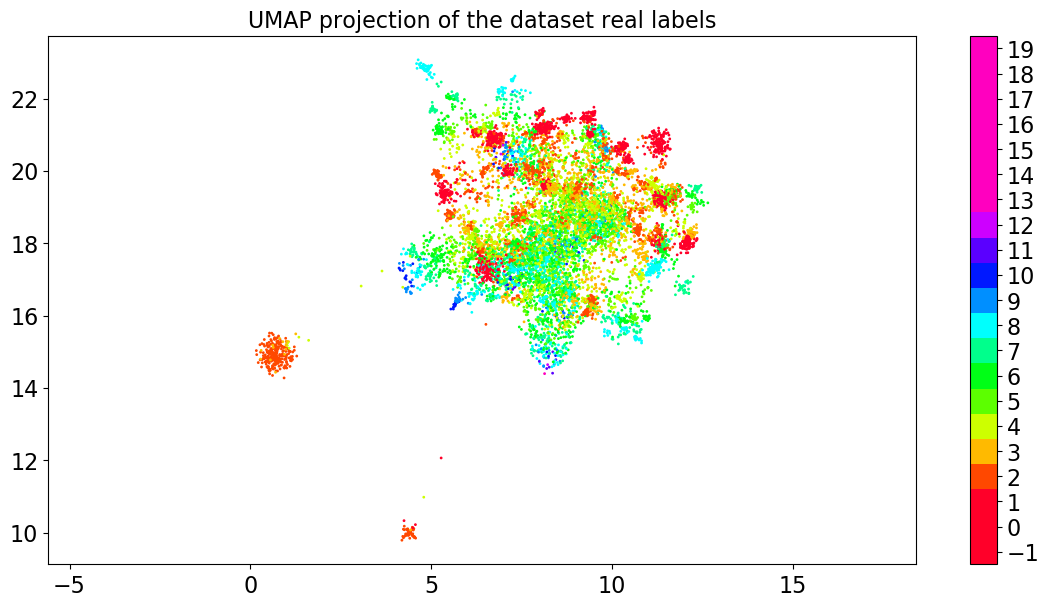

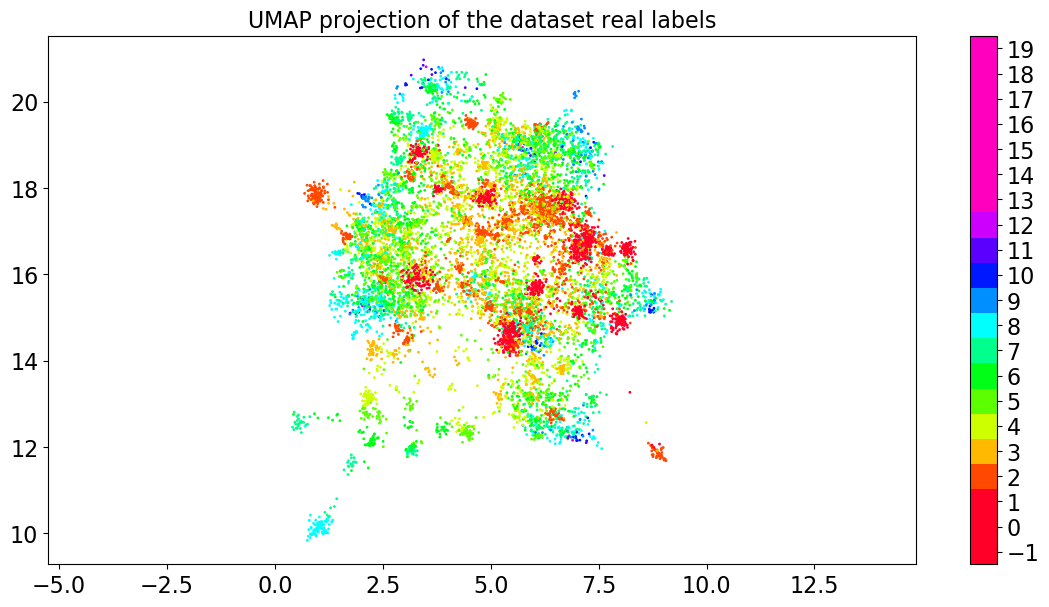

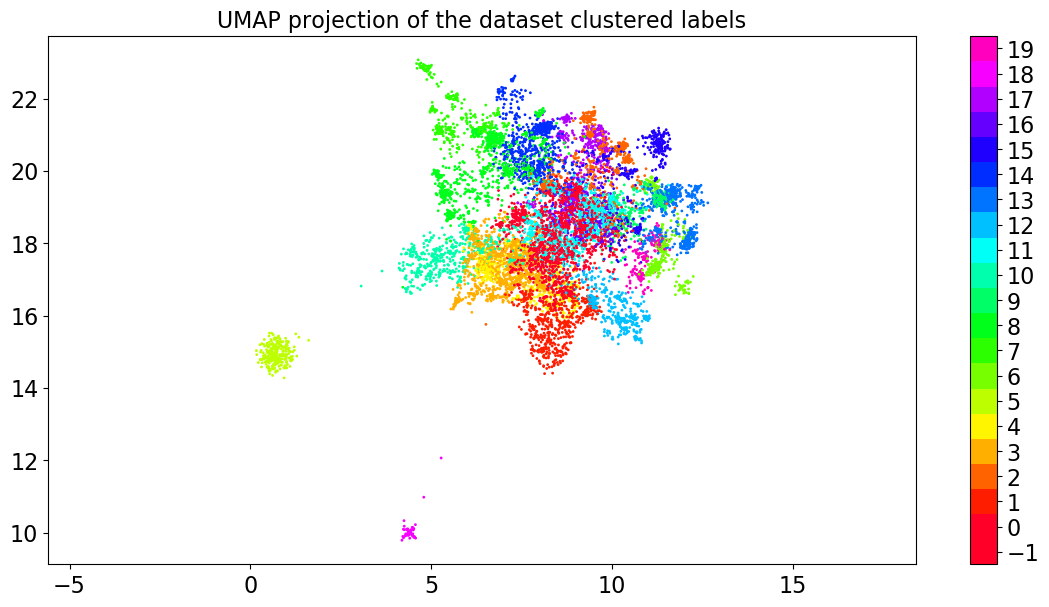

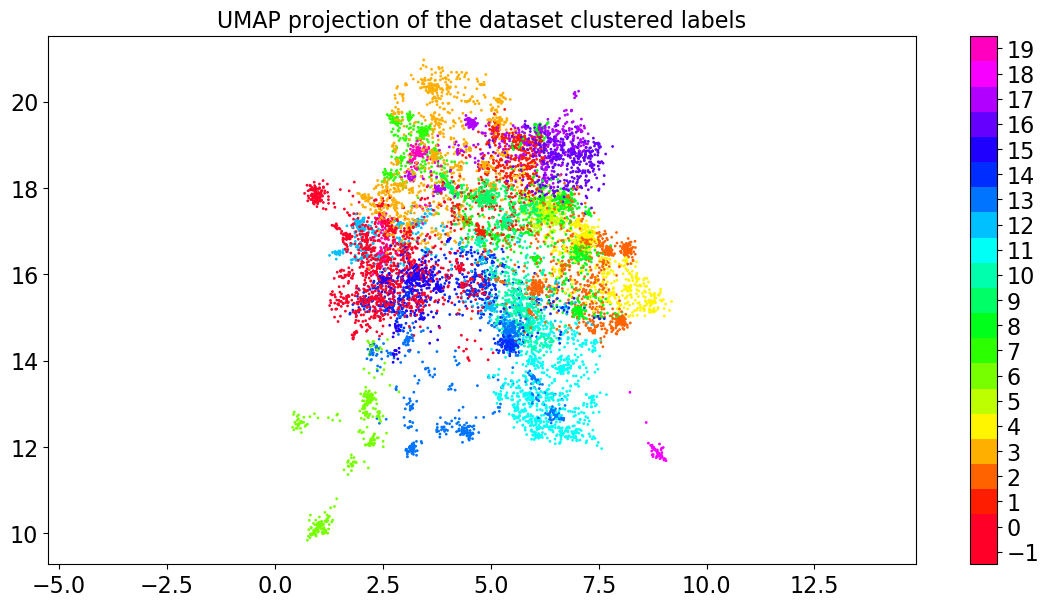

In [29]:
# n_clusters = len(old_clusters)
# k = KMeans(n_clusters).fit(embedding)

# n_clusters = len(old_clusters)
# # n_clusters = 20
# k = GaussianMixture(n_clusters).fit(embedding)
# k.labels_ = k.predict(embedding)

# k = DBSCAN(0.9).fit(embedding)
# n_clusters = max(k.labels_) + 1

# k = hdbscan.HDBSCAN(min_cluster_size=len(data)//200, gen_min_span_tree=True).fit(embedding)
# n_clusters = max(k.labels_) + 1

# # Visualization of HDBSCAN
# import seaborn as sns
# k.minimum_spanning_tree_.plot(edge_cmap='viridis',
#                                       edge_alpha=0.6,
#                                       node_size=10,
#                                       edge_linewidth=1)
# plt.show()

# k.condensed_tree_.plot()
# plt.show()

# k.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
# plt.show()

rcParams['figure.figsize'] = 14, 7
rcParams['figure.dpi'] = 100
rcParams.update({'font.size': 16})

plt.scatter(embedding[:, 0], embedding[:, 1], c=old_labels, s=1, cmap='gist_rainbow')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(-1, n_clusters+1)-0.5).set_ticks(np.arange(-1, n_clusters))
plt.title('UMAP projection of the dataset real labels', fontsize=16)
plt.show()

if embedding.shape[1] >= 4:
    plt.scatter(embedding[:, 2], embedding[:, 3], c=old_labels, s=1, cmap='gist_rainbow')
    plt.gca().set_aspect('equal', 'datalim')
    plt.colorbar(boundaries=np.arange(-1, n_clusters+1)-0.5).set_ticks(np.arange(-1, n_clusters))
    plt.title('UMAP projection of the dataset real labels', fontsize=16)
    plt.show()

plt.scatter(embedding[:, 0], embedding[:, 1], c=k.labels_, s=1, cmap='gist_rainbow')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(-1, n_clusters+1)-0.5).set_ticks(np.arange(-1, n_clusters))
plt.title('UMAP projection of the dataset clustered labels', fontsize=16)
plt.show()

if embedding.shape[1] >= 4:
    plt.scatter(embedding[:, 2], embedding[:, 3], c=k.labels_, s=1, cmap='gist_rainbow')
    plt.gca().set_aspect('equal', 'datalim')
    plt.colorbar(boundaries=np.arange(-1, n_clusters+1)-0.5).set_ticks(np.arange(-1, n_clusters))
    plt.title('UMAP projection of the dataset clustered labels', fontsize=16)
    plt.show()

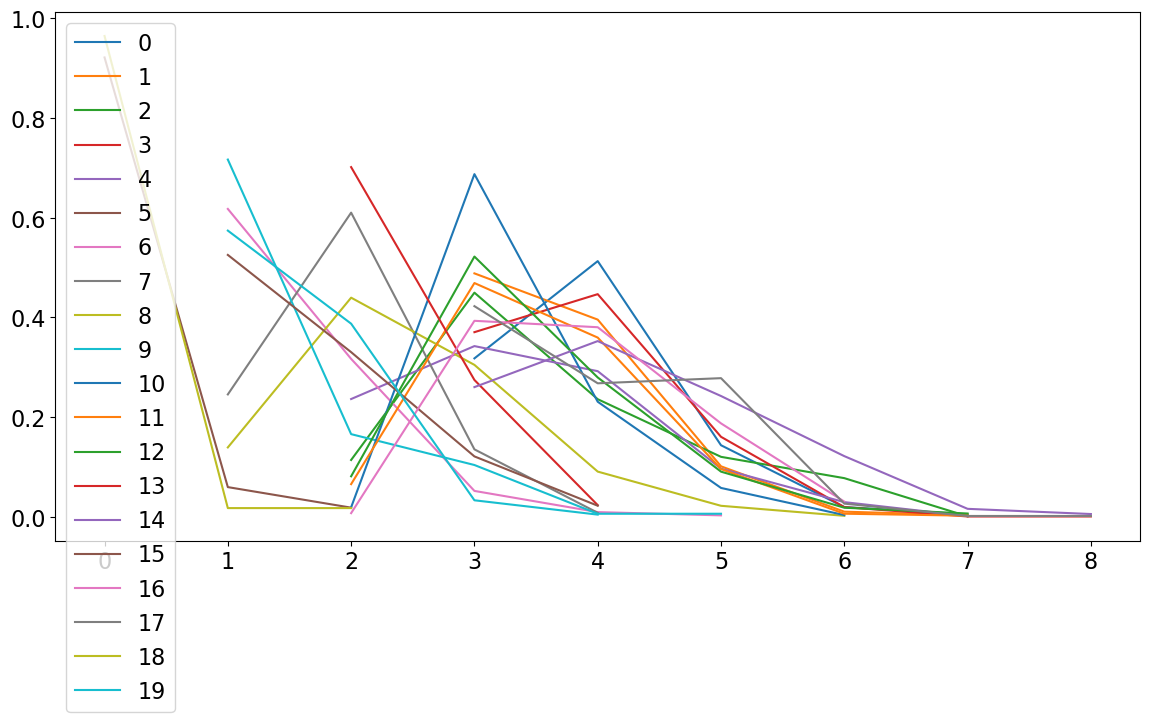

In [30]:
# print(f"number of approvals per cluster: {np.sum(cluster_mean, 1)}")
cluster_size = Counter(k.labels_) 

distance = {i:{} for i in range(-1,n_clusters)}
cluster_centers_ = [np.mean(data[k.labels_ == i],0) for i in range(n_clusters)]
for c, ballot in zip(k.labels_, data):
    dis = int(np.abs(ballot - cluster_centers_[c]).sum())
    try:
        distance[c][dis] += 1/cluster_size[c]
    except KeyError:
        distance[c][dis] = 1/cluster_size[c]
        
for c, dist in distance.items():
    plt.plot(*zip(*sorted(dist.items())), label=c)
plt.legend()
plt.show()

0
{0: 0.4376083188908146, 1: 0.3310225303292894, 2: 0.24956672443674177, 3: 0.24350086655112652, 4: 0.8136915077989602, 5: 0.09445407279029462, 6: 0.8370883882149047, 7: 0.561525129982669, 8: 0.354419410745234, 9: 0.0415944540727903, 10: 0.012998266897746967, 11: 0.2391681109185442, 12: 0.010398613518197574, 13: 0.3925476603119584, 14: 0.00779896013864818, 15: 0.004332755632582322, 16: 0.0034662045060658577, 17: 0.012998266897746967, 18: 0.0034662045060658577, 19: 0.0}
1154


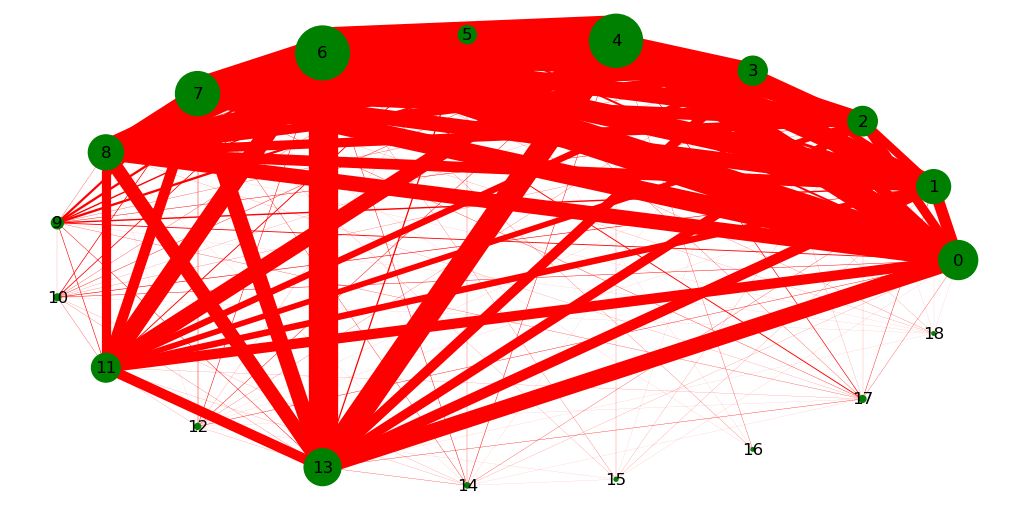

1
{0: 0.9696969696969697, 1: 0.1051693404634581, 2: 0.9750445632798574, 3: 0.09269162210338681, 4: 0.1140819964349376, 5: 0.44206773618538325, 6: 0.0035650623885918, 7: 0.08912655971479501, 8: 0.023172905525846704, 9: 0.0873440285204991, 10: 0.0766488413547237, 11: 0.5597147950089126, 12: 0.37076648841354726, 13: 0.0071301247771836, 14: 0.3850267379679144, 15: 0.0053475935828877, 16: 0.0053475935828877, 17: 0.5918003565062389, 18: 0.0017825311942959, 19: 0.41889483065953653}
561


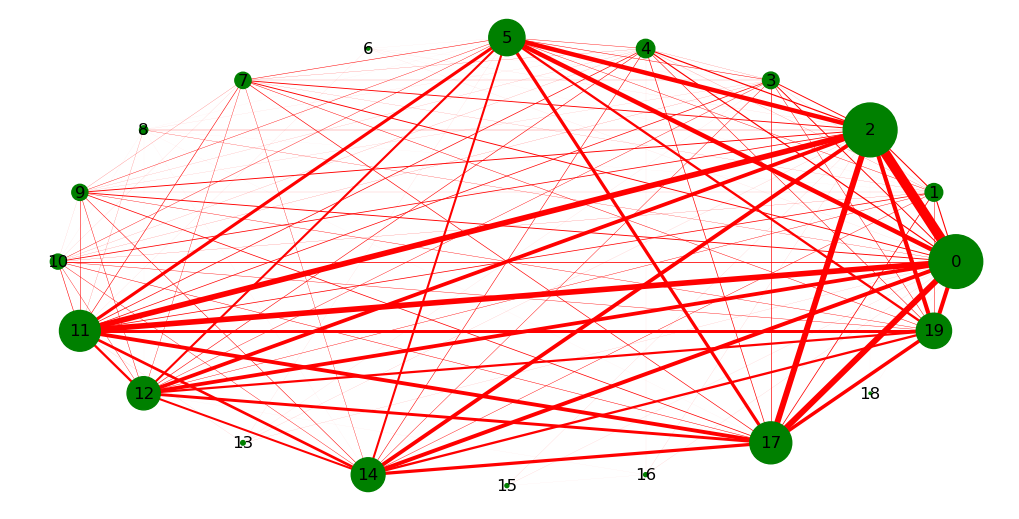

2
{0: 0.13316582914572864, 1: 0.29396984924623115, 2: 0.20728643216080403, 3: 0.5163316582914573, 4: 0.008793969849246231, 5: 0.06030150753768844, 6: 0.04522613065326633, 7: 0.12562814070351758, 8: 0.11809045226130653, 9: 0.13693467336683418, 10: 0.32537688442211055, 11: 0.03015075376884422, 12: 0.011306532663316583, 13: 0.11683417085427136, 14: 0.43467336683417085, 15: 0.3693467336683417, 16: 0.010050251256281407, 17: 0.01256281407035176, 18: 0.013819095477386936, 19: 0.007537688442211055}
796


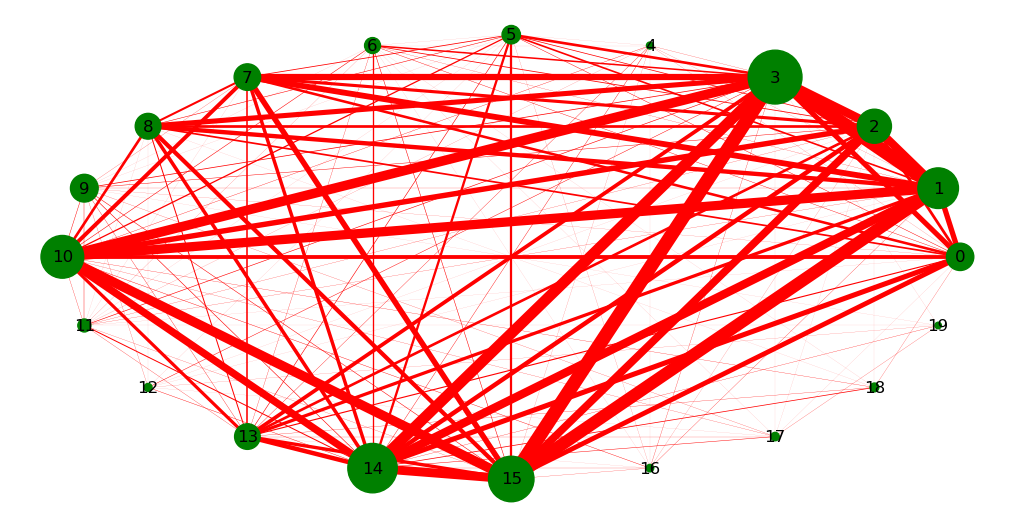

3
{0: 0.8903966597077244, 1: 0.3768267223382046, 2: 0.697286012526096, 3: 0.11899791231732777, 4: 0.6910229645093946, 5: 0.94258872651357, 6: 0.13569937369519833, 7: 0.4707724425887265, 8: 0.675365344467641, 9: 0.22755741127348644, 10: 0.06680584551148225, 11: 0.35386221294363257, 12: 0.08455114822546973, 13: 0.08350730688935282, 14: 0.017745302713987474, 15: 0.0041753653444676405, 16: 0.0020876826722338203, 17: 0.007306889352818371, 18: 0.0, 19: 0.0041753653444676405}
958


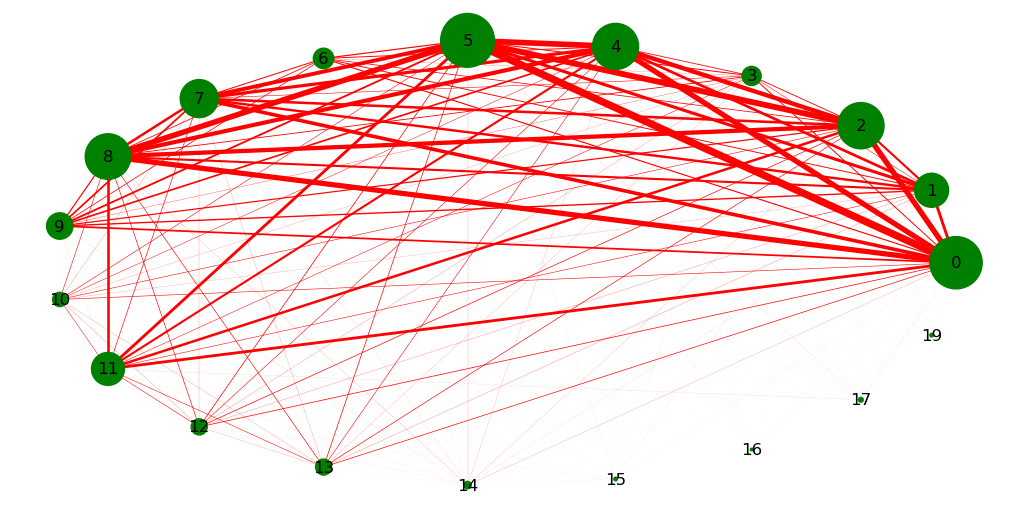

4
{0: 0.9832402234636871, 1: 0.47113594040968343, 2: 0.055865921787709494, 3: 0.0260707635009311, 4: 0.08752327746741155, 5: 0.01675977653631285, 6: 0.26256983240223464, 7: 0.0037243947858473, 8: 0.0111731843575419, 9: 0.0111731843575419, 10: 0.2644320297951583, 11: 0.10614525139664804, 12: 0.0148975791433892, 13: 0.35940409683426444, 14: 0.4860335195530726, 15: 0.00558659217877095, 16: 0.09124767225325885, 17: 0.32774674115456237, 18: 0.35940409683426444, 19: 0.01675977653631285}
537


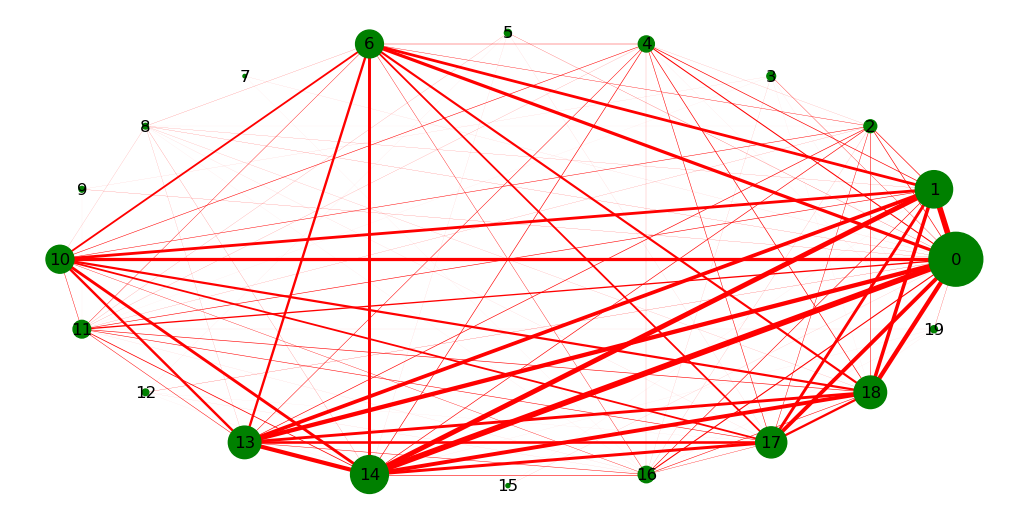

5
{0: 0.00749063670411985, 1: 0.003745318352059925, 2: 0.00749063670411985, 3: 1.0, 4: 1.0, 5: 0.00749063670411985, 6: 0.0, 7: 0.00749063670411985, 8: 0.0149812734082397, 9: 0.00749063670411985, 10: 0.0, 11: 0.0, 12: 0.011235955056179775, 13: 0.0149812734082397, 14: 0.003745318352059925, 15: 0.00749063670411985, 16: 0.0, 17: 0.0, 18: 0.003745318352059925, 19: 0.0}
267


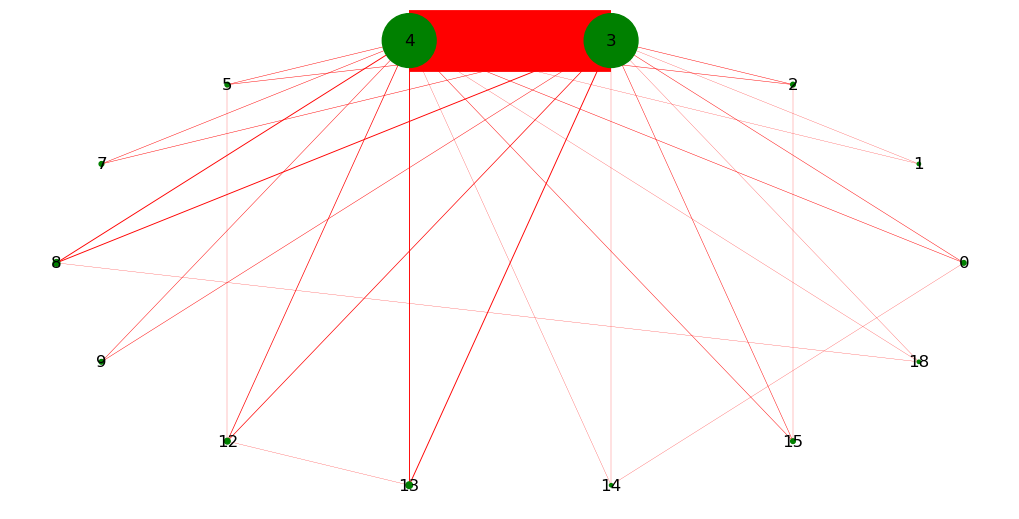

6
{0: 0.013071895424836602, 1: 0.013071895424836602, 2: 0.7156862745098039, 3: 0.5686274509803921, 4: 0.0, 5: 0.0032679738562091504, 6: 0.9967320261437909, 7: 0.434640522875817, 8: 0.9934640522875817, 9: 0.9967320261437909, 10: 0.9019607843137255, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.4444444444444444, 16: 0.0, 17: 0.0032679738562091504, 18: 0.0, 19: 0.0}
306


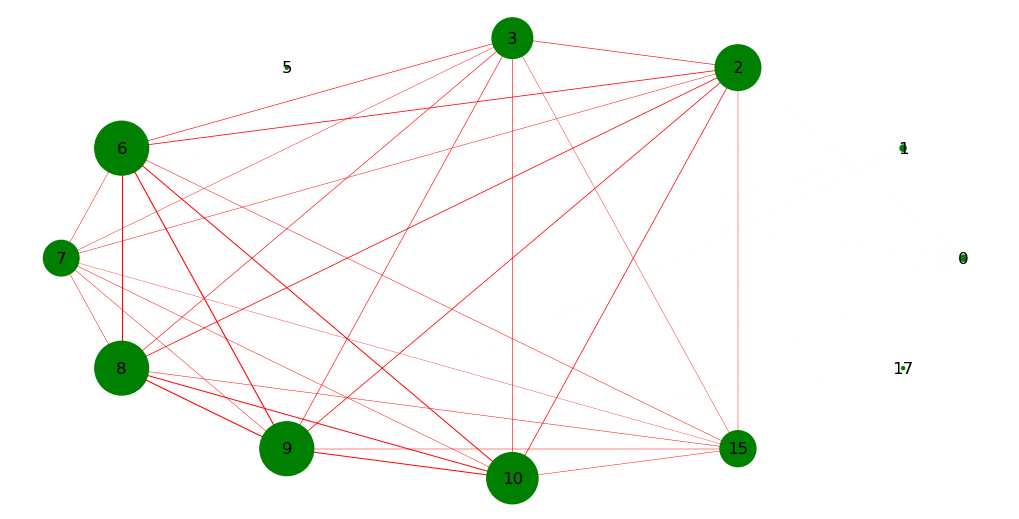

7
{0: 0.3022598870056497, 1: 0.00847457627118644, 2: 0.0, 3: 0.0, 4: 0.8700564971751412, 5: 0.0, 6: 0.6666666666666666, 7: 0.268361581920904, 8: 0.0, 9: 0.6666666666666666, 10: 0.0, 11: 0.943502824858757, 12: 0.8926553672316384, 13: 0.002824858757062147, 14: 0.0, 15: 0.0, 16: 0.9124293785310734, 17: 0.0, 18: 0.0, 19: 0.0}
354


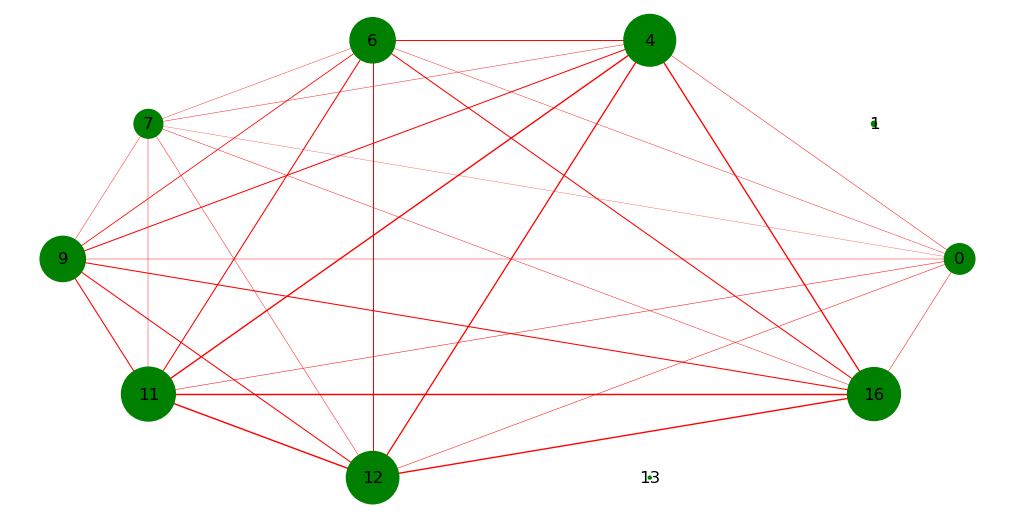

8
{0: 0.05555555555555555, 1: 0.09456264775413711, 2: 0.0035460992907801418, 3: 0.04491725768321513, 4: 0.31678486997635935, 5: 0.4988179669030733, 6: 0.02009456264775414, 7: 0.01773049645390071, 8: 0.04728132387706856, 9: 0.15484633569739953, 10: 0.03309692671394799, 11: 0.13356973995271867, 12: 0.12647754137115838, 13: 0.13002364066193853, 14: 0.06501182033096926, 15: 0.054373522458628844, 16: 0.11347517730496454, 17: 0.06028368794326241, 18: 0.00591016548463357, 19: 0.010638297872340425}
846


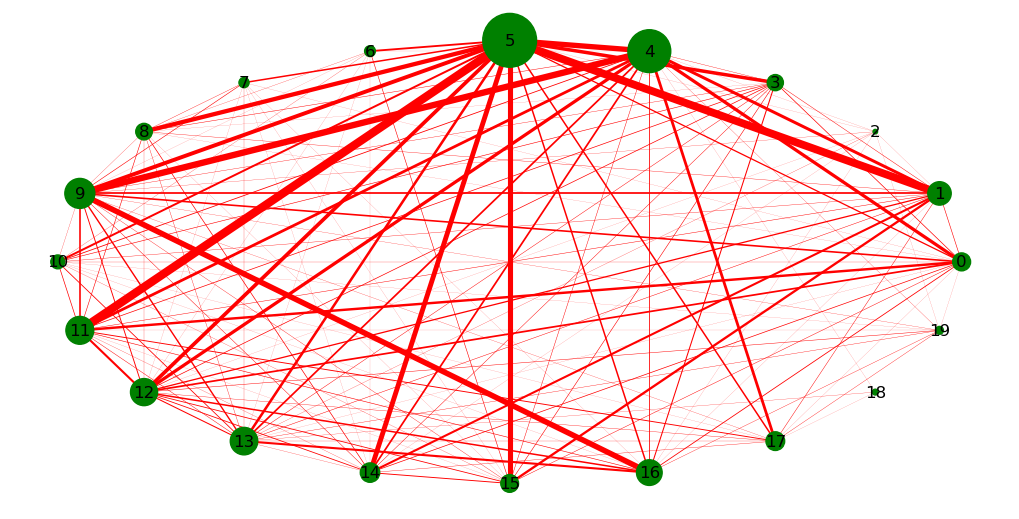

9
{0: 0.016286644951140065, 1: 0.019543973941368076, 2: 0.9837133550488599, 3: 0.1237785016286645, 4: 0.10423452768729642, 5: 0.006514657980456026, 6: 0.016286644951140065, 7: 0.10749185667752444, 8: 0.029315960912052116, 9: 0.035830618892508145, 10: 0.048859934853420196, 11: 0.09771986970684039, 12: 0.0749185667752443, 13: 0.016286644951140065, 14: 0.22149837133550487, 15: 0.03257328990228013, 16: 0.003257328990228013, 17: 0.04234527687296417, 18: 0.0, 19: 0.03908794788273615}
307


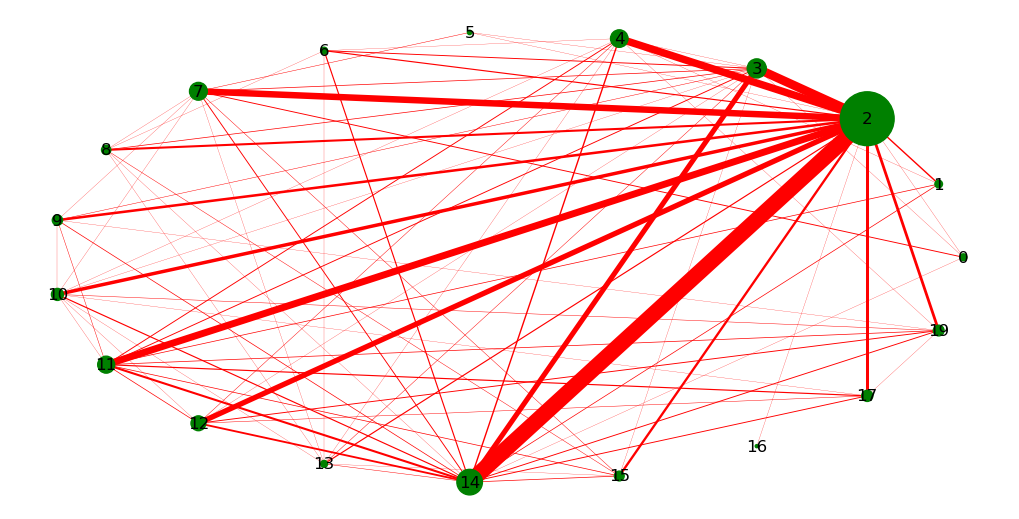

10
{0: 0.970873786407767, 1: 0.02330097087378641, 2: 0.13592233009708737, 3: 0.4601941747572815, 4: 0.5475728155339806, 5: 0.7708737864077669, 6: 0.017475728155339806, 7: 0.10679611650485436, 8: 0.001941747572815534, 9: 0.2174757281553398, 10: 0.011650485436893204, 11: 0.007766990291262136, 12: 0.44854368932038835, 13: 0.7650485436893204, 14: 0.003883495145631068, 15: 0.001941747572815534, 16: 0.5495145631067961, 17: 0.0, 18: 0.005825242718446602, 19: 0.10097087378640776}
515


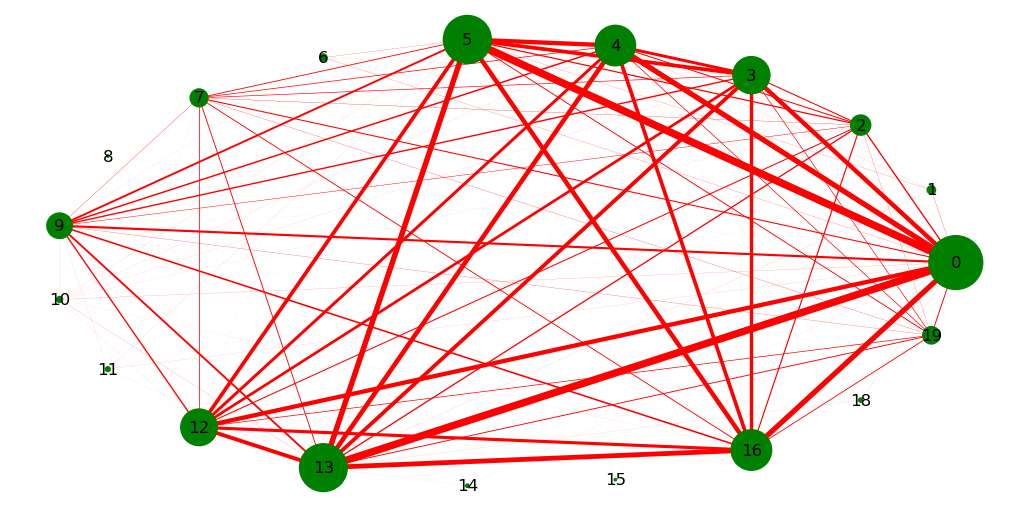

11
{0: 0.5164690382081687, 1: 0.9169960474308301, 2: 0.10408432147562582, 3: 0.857707509881423, 4: 0.0764163372859025, 5: 0.007905138339920948, 6: 0.09354413702239789, 7: 0.1251646903820817, 8: 0.7180500658761528, 9: 0.3926218708827404, 10: 0.3794466403162055, 11: 0.09354413702239789, 12: 0.10935441370223979, 13: 0.7720685111989459, 14: 0.017127799736495388, 15: 0.06324110671936758, 16: 0.005270092226613966, 17: 0.002635046113306983, 18: 0.08695652173913043, 19: 0.0013175230566534915}
759


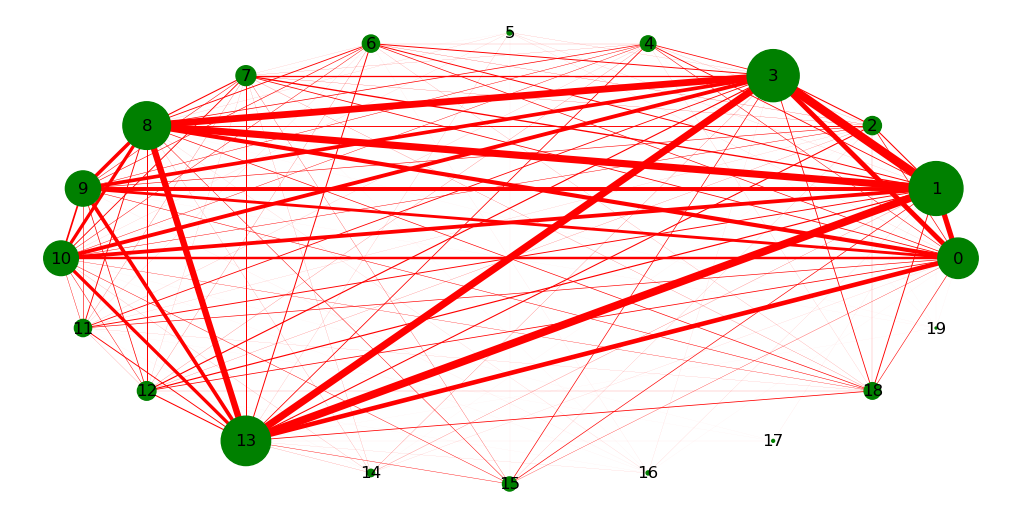

12
{0: 0.9137529137529138, 1: 0.29603729603729606, 2: 0.7342657342657343, 3: 0.018648018648018648, 4: 0.25874125874125875, 5: 0.002331002331002331, 6: 0.6736596736596736, 7: 0.682983682983683, 8: 0.5081585081585082, 9: 0.03496503496503497, 10: 0.02097902097902098, 11: 0.009324009324009324, 12: 0.5804195804195804, 13: 0.07692307692307693, 14: 0.02097902097902098, 15: 0.002331002331002331, 16: 0.0, 17: 0.0, 18: 0.3006993006993007, 19: 0.0}
429


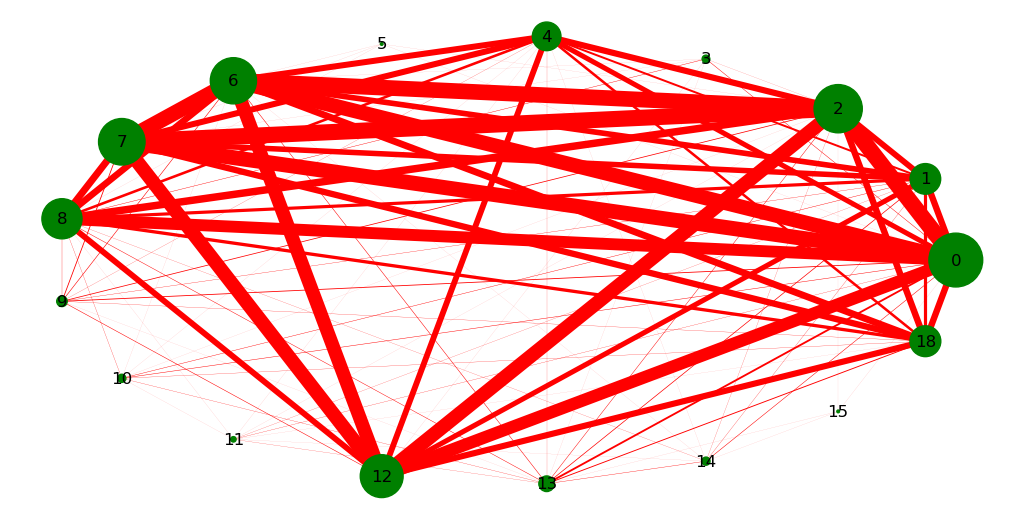

13
{0: 0.005494505494505495, 1: 0.04212454212454213, 2: 0.031135531135531136, 3: 0.32783882783882784, 4: 0.005494505494505495, 5: 0.003663003663003663, 6: 0.5421245421245421, 7: 0.19230769230769232, 8: 0.9853479853479854, 9: 0.6245421245421245, 10: 0.40293040293040294, 11: 0.003663003663003663, 12: 0.003663003663003663, 13: 0.018315018315018316, 14: 0.01098901098901099, 15: 0.1446886446886447, 16: 0.005494505494505495, 17: 0.0, 18: 0.003663003663003663, 19: 0.0}
546


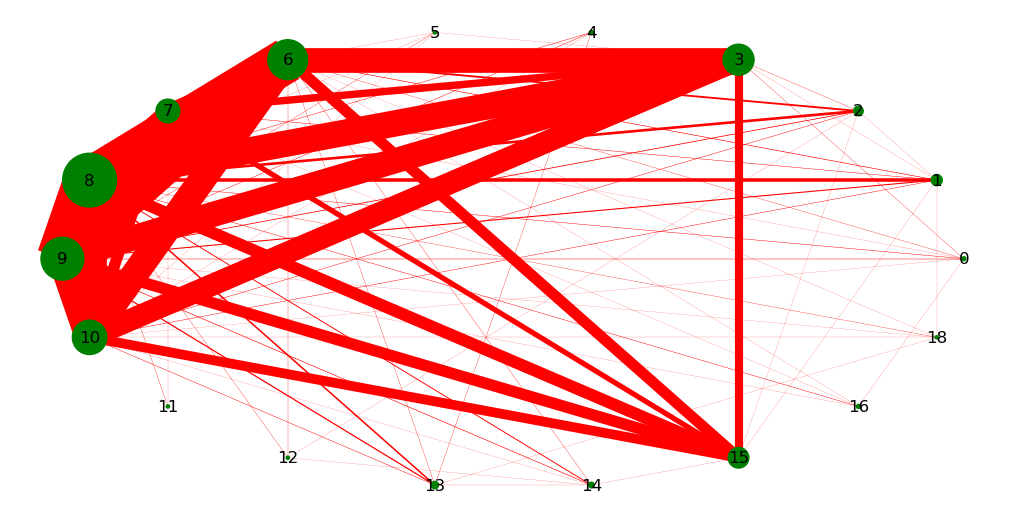

14
{0: 0.06994047619047619, 1: 0.9315476190476191, 2: 0.01488095238095238, 3: 0.15327380952380953, 4: 0.23065476190476192, 5: 0.5119047619047619, 6: 0.4270833333333333, 7: 0.30654761904761907, 8: 0.028273809523809524, 9: 0.5059523809523809, 10: 0.052083333333333336, 11: 0.23065476190476192, 12: 0.2425595238095238, 13: 0.32589285714285715, 14: 0.18601190476190477, 15: 0.0818452380952381, 16: 0.001488095238095238, 17: 0.10267857142857142, 18: 0.01636904761904762, 19: 0.002976190476190476}
672


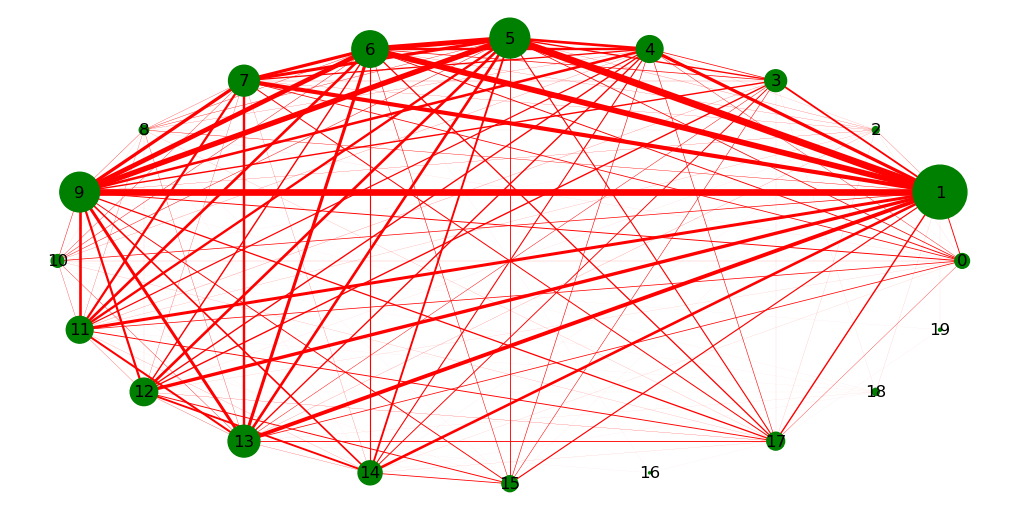

15
{0: 0.01694915254237288, 1: 0.1807909604519774, 2: 0.062146892655367235, 3: 0.01977401129943503, 4: 0.0, 5: 0.0480225988700565, 6: 1.0, 7: 0.2401129943502825, 8: 0.03389830508474576, 9: 0.2401129943502825, 10: 0.07909604519774012, 11: 0.07627118644067797, 12: 0.03954802259887006, 13: 0.059322033898305086, 14: 0.031073446327683617, 15: 0.00847457627118644, 16: 0.011299435028248588, 17: 0.03672316384180791, 18: 0.011299435028248588, 19: 0.0}
354


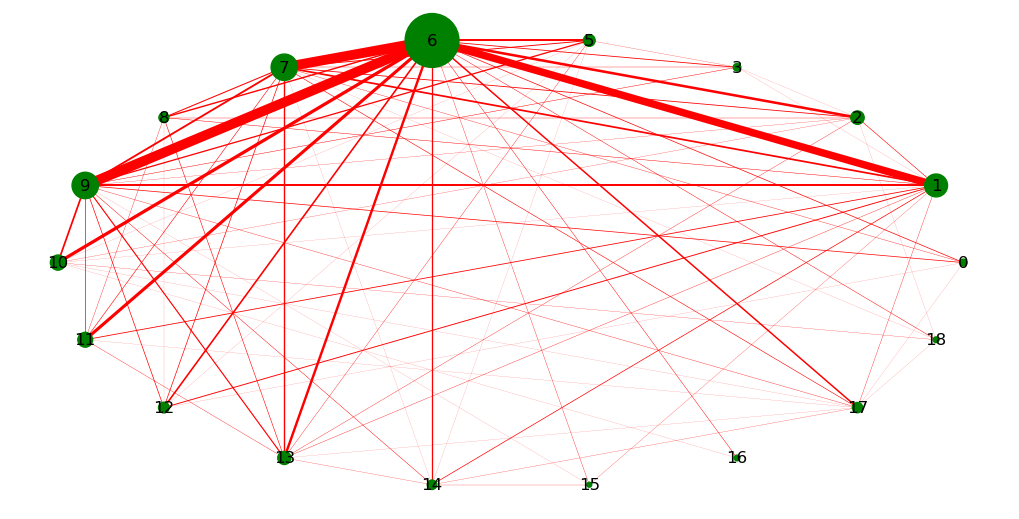

16
{0: 0.08740359897172237, 1: 0.09768637532133675, 2: 0.9537275064267352, 3: 0.7300771208226221, 4: 0.22879177377892032, 5: 0.7455012853470437, 6: 0.056555269922879174, 7: 0.10796915167095116, 8: 0.5578406169665809, 9: 0.08997429305912596, 10: 0.29048843187660667, 11: 0.11825192802056556, 12: 0.11053984575835475, 13: 0.32390745501285345, 14: 0.9511568123393316, 15: 0.6298200514138818, 16: 0.007712082262210797, 17: 0.0, 18: 0.0, 19: 0.005141388174807198}
389


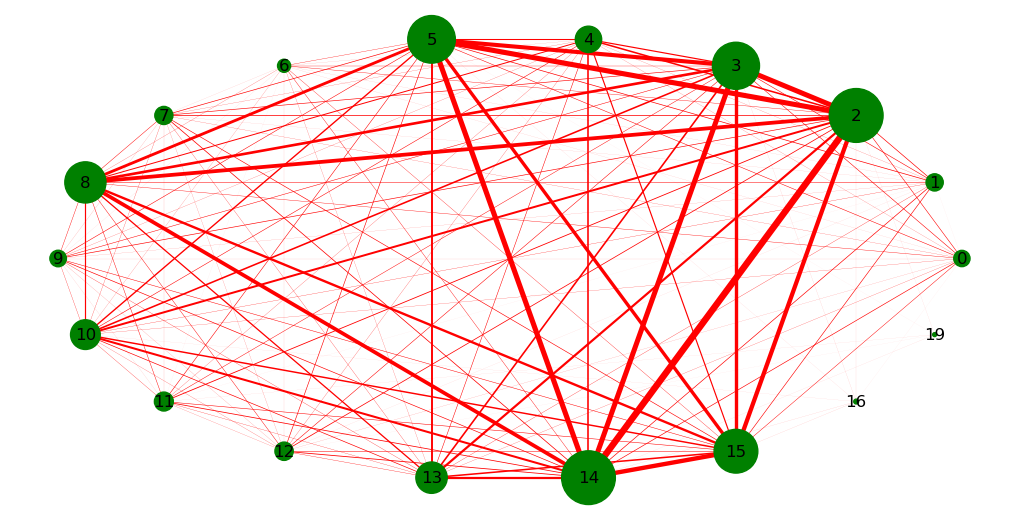

17
{0: 0.16288659793814433, 1: 0.15463917525773196, 2: 0.7484536082474227, 3: 0.1422680412371134, 4: 0.10927835051546392, 5: 0.8206185567010309, 6: 0.31958762886597936, 7: 0.032989690721649485, 8: 0.09896907216494845, 9: 0.016494845360824743, 10: 0.5010309278350515, 11: 0.12371134020618557, 12: 0.030927835051546393, 13: 0.018556701030927835, 14: 0.26597938144329897, 15: 0.5381443298969072, 16: 0.14845360824742268, 17: 0.018556701030927835, 18: 0.0, 19: 0.004123711340206186}
485


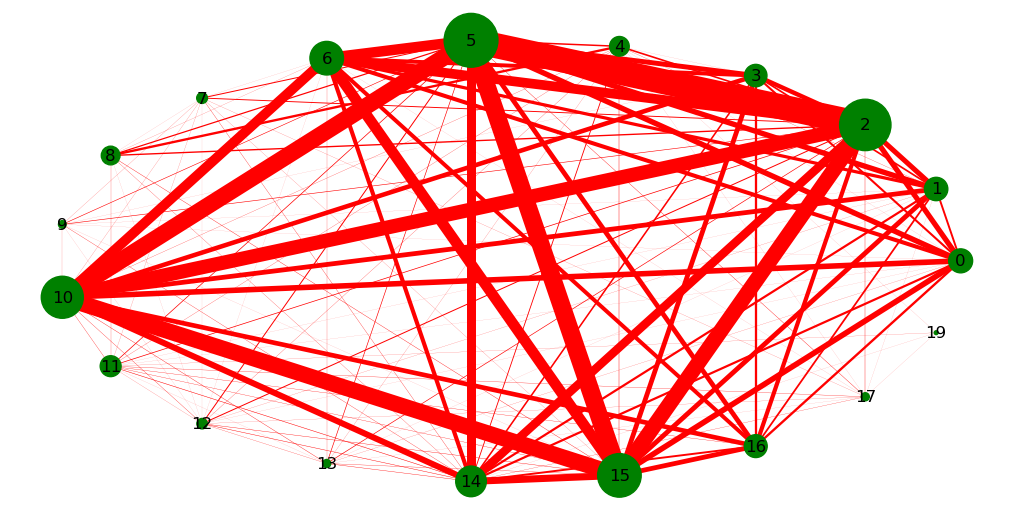

18
{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.9285714285714286, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.017857142857142856, 15: 0.0, 16: 0.0, 17: 0.03571428571428571, 18: 0.0, 19: 1.0}
56


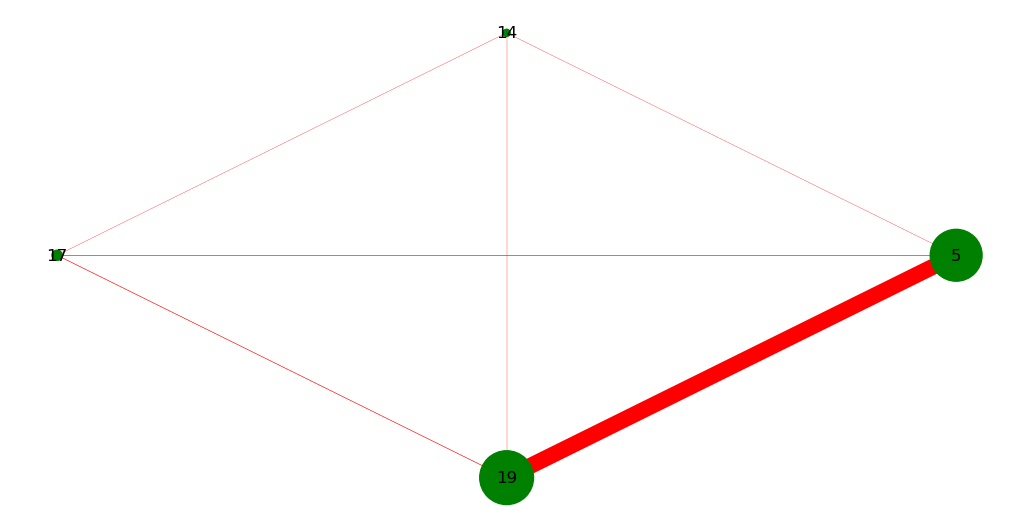

19
{0: 0.009569377990430622, 1: 0.03827751196172249, 2: 0.4449760765550239, 3: 0.014354066985645933, 4: 0.0, 5: 0.004784688995215311, 6: 0.47368421052631576, 7: 0.9760765550239234, 8: 0.03349282296650718, 9: 0.03827751196172249, 10: 0.004784688995215311, 11: 0.0, 12: 0.39712918660287083, 13: 0.019138755980861243, 14: 0.004784688995215311, 15: 0.004784688995215311, 16: 0.0, 17: 0.019138755980861243, 18: 0.10526315789473684, 19: 0.004784688995215311}
209


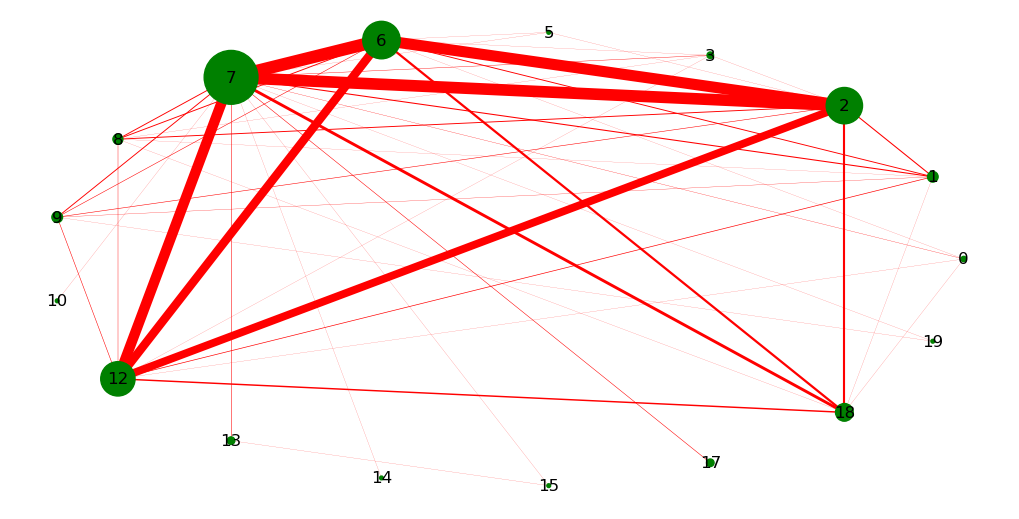

In [31]:
data = data.astype(float)
clusters = [data[k.labels_ == i] for i in range(n_clusters)]
# clusters = old_clusters
for see_cluster in range(n_clusters):
    print(see_cluster)
    print({i:x for i,x in enumerate(np.mean(clusters[see_cluster],0))})
    print(len(clusters[see_cluster]))
    cluster_0 = Counter([tuple(np.where(x == 1)[0]) for x in clusters[see_cluster]])

    edge_dict = {}
    for key,value in cluster_0.items():
        for perm in permutations(key, 2):
            try:
                edge_dict[(perm[0], perm[1])] += value
            except KeyError:
                try: 
                    edge_dict[(perm[1], perm[0])] += value
                except KeyError:
                    edge_dict[(perm[0], perm[1])] = value

    edge_list = [(*key, {'weight':value}) for key,value in edge_dict.items()]
    
    G = nx.Graph()
    G.add_nodes_from(sorted(set([y for x in cluster_0.keys() for y in x])))
    G.add_edges_from(edge_list)
    rcParams['figure.figsize'] = 10, 5
    rcParams['figure.dpi'] = 100
    options = {
        'node_color': 'g',
        'edge_color':'r'
    }
    edges = G.edges()
    weights = [G[u][v]['weight'] for u,v in edges]
    weights /= np.median(weights)*3
    
    nodes = G.nodes()
    s = np.sum(clusters[see_cluster],0)
    s /= max(s)
    s *= 1500
    node_size = [s[n] for n in nodes]

    nx.draw_circular(G, node_size=node_size, with_labels=True, edgelist=edges, width=weights, **options)
    plt.show()
